In [1]:
try:    importlib.reload(Jupytils)
except: import Jupytils
showTopbar("Crystal Ball Examples", menu=[("Help", "#"), ("Home", "#")])

import pymc3 as pymc3
from pymc3 import *
from numpy import median
from scipy import optimize
import openpyxl

<IPython.core.display.Javascript object>

In [9]:
#********** DO NOT USE THIS IF ALL THE TABLE CONTENTS ARE NOT SHOWING
#
cellJAVASCRIPT='''
v2 = $('{}_searchResults')

td = $('{} tr').eq({}).find('td').eq({});
//console.log(r, c,td.text())
td.attr('title', '{}')
td.css('background-color', '{}')
td.css('border', '2px {} solid')
td.css('background-image', 'url(nnormal.png)')
td.css('background-size', '80px')
td.css('background-repeat', 'no-repeat')
td.focusin (function(){{
    v2.text($(this).attr('title'))
//    console.log('sadass')
}});
'''
def getOurCodedCells(df2):
    detrs = {}
    probs = {}
    for i, r in df2.iterrows():
        cc= -1;
        for j, c in r.iteritems():
            c = str(c).strip()
            cc += 1;
            if ( c.find('pymc3') >= 0):
                if( c.find('Deterministic') < 0 ):
                    probs[(i+1, cc+1)] = c;
                else:
                    detrs[(i+1, cc+1)] = c;
    return probs, detrs


def setCellFormat(df2, dictItems={}, background='', border='blue'):
    scr = "<script>\n"
    tableID = "#"+ df2.tableID
    for k, f in dictItems.items(): 
        c1, c2 = k
        ff = f.replace("'", r"\'")
        scr += cellJAVASCRIPT.format(tableID,tableID, c1,c2-1,ff, background, border)
    scr+="</script>\n"

    display(HTML(scr))
    
def HighlightDF(df2):
    probs, detrs = getOurCodedCells(df2)
    
    setCellFormat(df2, df2.formulas,'', 'blue')
    setCellFormat(df2, probs,'', 'green')
    setCellFormat(df2, detrs,'', 'cyan')
    return probs, detrs, df2.formulas
    
def showExcelDF(df2):
    if (len(df2) > 500):
        return "Max Rows Exceeded"
    displayDFs(df2, showIcons=False, maxrows=len(df2));

    probs, detrs, df2.formulas = HighlightDF(df2)
    return probs, detrs, df2.formulas



In [159]:
fileName="Cell Phone.xlsx"; sheetname='Model'
fileName="cb2.xlsx"; sheetname=0
#fileName="nogit/lrp/fin.xlsx";sheetname='Crystal Ball Model'
df2= LoadDataSet(fileName, sheetname=sheetname)
p,d,f = showExcelDF(df2)

,A,B,C
0,Costs,inMillions,Distributions
1,Development Cost of ClearView to Date,10,
2,Testing Costs,4,"B3 = pymc3.Uniform('Testing Cost', 3,5)"
3,Marketing Costs,16,"B4 = Triangular(""Marketing Cost"", 12,18,16) #Pymc3"
4,Total Costs,30,
5,(sample of 100 patients),,
6,Drug Test,,
7,Patients Cured,100,"B8 = pymc3.Binomial(""Patients Cured"", 100,.25)"
8,FDA Approved if 20 or More Patients Cured,1,
9,(in millions),,


In [160]:
###=== How best to manage assumptions
# 1. within in Excel
# 2. outside of Excel
#

tableID = "#"+ df2.tableID
tdh=r'''
<h3>Add Assumptions:</h3>
<div style="border-bottom: 1px #dddddd solid;"/>
Cell/Variable: <input type="text" id="assump">
<iimg src="normal.png" width="96px">
<br/>
<select id="listass" size="10" style="height:100pxß;">
    <option value=""></option>
    <option value="Normal(\'Name\', mu=0, sd=0 )">Normal(\'Name\', mu=0, sd=0 ) <img src="normal.png"> > <img src="normal.png"> </option>
    <option value="Triangular(\'Name\', l=.1, h=.5,max=.7 )">Triangular(\'Name\', l=.1, h=.5,max=.7 )</option>
</select><br/>

</script>
<script>
$("#proexample").on("change",function() {{
    var v = this.value;
    if (v=="") return; 

    $('#protext').val(v); 
  }}); 
</script>  
'''

#display(HTML(tdh))


In [204]:
#Excel functions

def SUM(ran):
    a=[]
    for r in openpyxl.utils.cols_from_range('B2:B4'):
        for j in r:
            f = eval(j)
            a.append(f)
    s = 0;
    ret = np.array(a).sum()
    return ret 

def IFP(fun):
    f1 = fun.split(',')
    lm ='''({}) if ({}) else ({})'''.format(f1[1], f1[0], f1[2]);
    return (lm)

def IF(fun):
    lm = IFP(fun)
    return eval(lm)

def LAMBDA(ss, funcs=None):
    EXCEL_FUNCS = ['SUM', 'IF']
    
    s = ss.strip();
    s = s[1:]
    fw = re.match(r'(\w+)', s).group()
    if (fw in EXCEL_FUNCS):
        ret = fw + "('" + s[len(fw)+1:-1] + "')" 
    else:
        ret =  ss[1:]
        
    ret = FUNC_REPL(ret, funcs)
    return ret
    
#s ='=SUM(B2:B4)'
#LAMBDA(s)
def FUNC_REPL(ss,funcs=None):
    if (funcs is None): return;
    ret = ss
    fw = set(re.findall(r'(\w+)', ss))
    for c in fw:
        if ( c in forms ):
            ret,p = re.subn('\\b{}\\b'.format(c), c+'()', string=ret)
    return ret

def PYMC3(cell, func):
    f = [f.strip() for f in func.split(',')]
    ret= (r"{:80s} # {:4s}".format(func, cell) )
    
    return ret;

In [163]:
def findAllCodedCells(df):
    forms = {}
    probs = []
    detrs = []
    vaars = [];

    for k,v in df2.formulas.keys():
        f = openpyxl.utils.get_column_letter(v)+ str(k)
        forms[f] = df2.formulas[(k,v)];
    
    for i, r in df2.iterrows():
        ic= 0;
        for j, c in r.iteritems():
            ic += 1                
            f = openpyxl.utils.get_column_letter(ic)+ str(i+1)
            
            if ( isinstance(c, numbers.Number)):
                vaars.append(f)  
                continue;
                
            nv =  c.strip()
            if (nv.startswith('#') or nv is None):
                continue;

            if ( nv.startswith('=')):
                forms[f] = nv;
                
            elif ( nv.find('pymc3') >= 0):
                if( c.find('Deterministic') < 0 ):
                    probs.append(f);
                else:
                    detrs.append(f);
                    
    return (forms, probs, detrs, vaars)

forms, probs, detrs, vaars= findAllCodedCells(df2)

In [171]:
def getVal(df, k):
    ret = "''"
    ci=re.findall('[a-z$A-Z_]+',k)[0]
    c=openpyxl.utils.column_index_from_string(ci)-1
    r=int(re.findall('[0-9]+',k)[0])-1
    ret = df2[df2.columns[c]][r]
    return ret;

vs = ""
for f in vaars:
    vs += '{} = {};  '.format(f, getVal(df2,f))
vs +='\n'

fs = ''
for f,v in forms.items():
    pv = LAMBDA(v, forms.keys())
    fs += ("{:4s} = lambda : {:40} # {}\n".format(f, pv, v) )

ps = ''
for f in probs:
    ps += '{}; # {}\n'.format(getVal(df2,f), f)

ds = ''
for f in detrs:
    ds += '{}; # {}\n'.format(getVal(df2,f), f)

pg ='''
{}
{}
with pymc3.Model() as mcmc:
    {}
    {}
    step = pymc3.Metropolis()
    traced = sample(1000, step)
'''.format(vs, fs, ps.replace('\n', '\n    '), ds.replace('\n', '\n    '));
print(pg)


B2 = 10;  B3 = 4;  B4 = 16;  B5 = 30;  B8 = 100;  B9 = 1;  B12 = 40;  B13 = 0.02;  B14 = 40.8;  B17 = 0.08;  B18 = 12;  B19 = 39.168;  B21 = 9.168;  

B19  = lambda : B14()*B17*B18                            # =B14*B17*B18
B14  = lambda : B12*(1+B13)                              # =B12*(1+B13)
B5   = lambda : SUM('B2:B4')                             # =SUM(B2:B4)
B21  = lambda : IF('B9(),B19()-B5(),-B2-B3')             # =IF(B9,B19-B5,-B2-B3)
B9   = lambda : IF('B8>=20,1,0')                         # =IF(B8>=20,1,0)

with pymc3.Model() as mcmc:
    B3 = pymc3.Uniform('Testing Cost', 3,5); # C3
    B8 = pymc3.Binomial("Patients Cured", 100,.25); # C8
    B17 = pymc3.Normal("Market Penetration",.08, .02); # C17
    
    pymc3.Deterministic("Gross Profit", B19()); # C19
    pymc3.Deterministic("Net Profit", B21()); # C21
    
    step = pymc3.Metropolis()
    traced = sample(1000, step)



In [154]:
'''k='=IF(D11<=C5,C4,$C$4+(C6*(D11-C5)))'
k=k.replace('$', '')
c=re.findall('\w+',k)
t=re.split('\w+',k)
print(c,t, len(c), len(t))'''
''

''

In [306]:
def genCB(v, rent=500):
    ret = v['Number Of Units'] * rent - v['Operating Cost']
    #ret = B8
    #if (ret > 20):
    #    retun70
    return ret

N={}
with pymc3.Model() as mcmc:
    pymc3.Uniform('Number Of Units', 30, 40);
    pymc3.Normal('Operating Cost', mu=15000, sd=1000 );
    B8 = pymc3.Binomial("Patients Cured", 100,.25); # C8
    
    for c in mcmc.unobserved_RVs:
        N[str(c)] = c
        
    ROI = Deterministic('ROI', genCB(N) )
    
    step = pymc3.Metropolis()
    traced = sample(1000, step)


100%|██████████| 1500/1500 [00:00<00:00, 2044.86it/s]


In [300]:
'''TypeError: Variables do not support boolean operations. This can happen if you do a logical operation (<, <=, >, <=, ==, !=) 
    between a numpy.ndarray and a Theano tensorvariable. 
    Due to NumPy implementation before NumPy 1.8, we cannot make the Python syntax work when the ndarray is on the left, and 
    this results in this error. To work around that, either call theano.tensor.{lt,le,eq,ne,gt,ge}(ndarray, tensor), or 
    use the Python syntax with the Theano tensor on the left. Or update to NumPy 1.8 or above.'''
B8C = theano.tensor.as_tensor_variable(20, name='B8C', ndim=None)
B8 > B8C


Elemwise{gt,no_inplace}.0

In [321]:

B2 = 10;  B3 = 4;  B4 = 16;  B5 = 30;  B8 = 100;  B9 = 1;  B12 = 40;  B13 = 0.02;  B14 = 40.8;  B17 = 0.08;  B18 = 12;  B19 = 39.168;  B21 = 9.168;  

B19  = lambda : B14()*B17*B18                            # =B14*B17*B18
B14  = lambda : B12*(1+B13)                              # =B12*(1+B13)
B5   = lambda : SUM('B2:B4')                             # =SUM(B2:B4)
B21  = lambda : IF('B9(),B19()-B5(),-B2-B3')             # =IF(B9,B19-B5,-B2-B3)
#B9   = lambda : IF('T.gt(B8,20), 1,0')
# =IF(B8>=20,1,0)
def B9(): return 1 if theano.tensor.gt(B8,20) else 0                         # =IF(B8>=20,1,0)


with pymc3.Model() as mcmc:
    B3 = pymc3.Uniform('Testing Cost', 3,5); # C3
    B8 = pymc3.Binomial("Patients Cured", 100,.25); # C8
    B17 = pymc3.Normal("Market Penetration",.08, .02); # C17
    
    pymc3.Deterministic("Gross Profit", B19()); # C19
    pymc3.Deterministic("Net Profit", B21()); # C21
    
    step = pymc3.Metropolis()
    traced = sample(1000, step)
    

100%|██████████| 1500/1500 [00:00<00:00, 2033.38it/s]


40.5467994334 10.9404924183
10.5235878084 10.9596925019


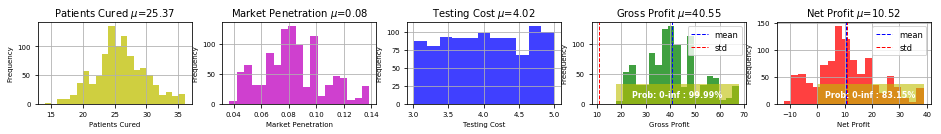

In [322]:
from theano.tensor.var import TensorVariable

plt.figure(figsize=(16,1.5))
facecolor='y,purple,c,blue,green,red'.split(',')
fc= 'ymbgrcmykw'*5;
varss = [v for v in traced.varnames if not v.endswith('_')]
detss = []
for m in mcmc.deterministics:
    s = str(m)
    if (type(m)) == TensorVariable and not s.endswith('_'):
        varss.remove(s)
        detss.append(s)

n=len(varss) + len(detss)
numberPerLine = 6
r = int(np.ceil(n/numberPerLine)) ; # plots per line 6 - count number of lines
c=min(n, numberPerLine)

for i,j in enumerate(varss):
    aj = np.mean(traced[j])
    subplot= int("{}{}{}".format(r,c,i+1) )
    title='{} $\mu$={:.2f}'.format(j,aj)
    plthist(traced[j], title=title, ylabel='Frequency', xlabel=j, facecolor=fc[i%len(fc)], subplot=subplot);

i += 1;
for j,k in enumerate(detss):
    aj = np.mean(traced[k])
    subplot= int("{}{}{}".format(r,c,i+j+1))
    title='{} $\mu$={:.2f}'.format(k,aj)
    yl = 'Freequency'
    plthist(traced[k], title=title, ylabel=yl, xlabel=k, facecolor=fc[(i+j)%len(fc)],  subplot=subplot, ablines=['mean', 'std'], legend=True, low=0, high=np.math.inf);

plt.subplots_adjust(wspace=None, hspace=.3)



In [328]:
import inspect
g=inspect.getsource(genCB)
print(g)

def genCB(v, rent=500):
    ret = v['Number Of Units'] * rent - v['Operating Cost']
    #ret = B8
    #if (ret > 20):
    #    retun70
    return ret

